## Github: Analyzing PRs, Issues and Forks

  * Do repositories with more issues lead to more Pull Requests? More Forks? Neither?

In [1]:
import gcp.bigquery as bq
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd

In [3]:
table = bq.Table('githubarchive:github.timeline')

In [7]:
table.sample( ['type',
               'repository_name',
               'repository_url',
               'repository_forks'])

QueryResultsTable job_ibhjVmH12vXCGeriW6dF1DoTKmU

In [9]:
%%sql --module github

DEFINE QUERY github_types
SELECT type, count(*) FROM [githubarchive:github.timeline] GROUP BY type;

In [11]:
bq.Query(github.github_types).results()

QueryResultsTable job_-d5vT9jVjy4ENBY9VlSdVoQctmE

In [25]:
%%sql --module github

DEFINE QUERY forks_issues_prs
SELECT repository_name, type, count(*) as count
FROM [githubarchive:github.timeline] 
WHERE type IN ('ForkEvent', 'PullRequestEvent', 'IssuesEvent')
GROUP BY repository_name, type;

In [26]:
query = bq.Query(github.forks_issues_prs)

In [27]:
df = query.to_dataframe()

In [28]:
df.head()

,repository_name,type,count
0,dropzone,ForkEvent,2113
1,PSAP,IssuesEvent,368
2,vaultmp,ForkEvent,23
3,2048,ForkEvent,13654
4,tern,IssuesEvent,559


In [33]:
df['fork_events'] = df.apply(lambda x: x['count'] if x['type'] == 'ForkEvent' else 0, axis=1 )

In [34]:
df['issues'] = df.apply(lambda x: x['count'] if x['type'] == 'IssuesEvent' else 0, axis=1 )

In [35]:
df['pull_requests'] = df.apply(lambda x: x['count'] if x['type'] == 'PullRequestEvent' else 0, axis=1)

In [36]:
df.head()

,repository_name,type,count,fork_events,issues,pull_requests
0,dropzone,ForkEvent,2113,2113,0,0
1,PSAP,IssuesEvent,368,0,368,0
2,vaultmp,ForkEvent,23,23,0,0
3,2048,ForkEvent,13654,13654,0,0
4,tern,IssuesEvent,559,0,559,0


In [71]:
agg_df = df.groupby('repository_name').agg({'fork_events': np.max,
                                            'issues': np.max,
                                            'pull_requests': np.max})

In [72]:
agg_df.head()

,fork_events,issues,pull_requests
repository_name,,,
-,39,71465,32
--,30,5,3
---,50,23,56
----,24,830,11
-----,4,14,2


In [39]:
agg_df.loc['pandas']

fork_events       1904
issues           12338
pull_requests     6805
Name: pandas, dtype: int64

In [40]:
agg_df.describe()

,fork_events,issues,pull_requests
count,1418737.000000,1418737.000000,1418737.000000
mean,7.074952,11.384694,7.897827
std,129.797799,324.103597,162.287800
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,3.000000,3.000000,2.000000
max,69325.000000,275554.000000,96123.000000


In [42]:
agg_df.corr()

,fork_events,issues,pull_requests
fork_events,1.000000,0.143728,0.280959
issues,0.143728,1.000000,0.200798
pull_requests,0.280959,0.200798,1.000000


In [43]:
agg_df.corr(method='spearman')

,fork_events,issues,pull_requests
fork_events,1.000000,-0.078702,0.365112
issues,-0.078702,1.000000,0.159426
pull_requests,0.365112,0.159426,1.000000


In [73]:
agg_df.T > 50

repository_name,-,--,---,----,-----,------,-------,--------,---------,----------,...,zzzcron,zzzdummy,zzzdummyrepo,zzzeek_pycon2014_atmcraft,zzzely.github.com,zzzhc.github.com,zzzine,zzzj,zzzzz,zzzzzzzzzzzzzzz
fork_events,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
issues,True,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
pull_requests,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [74]:
agg_df = agg_df[(agg_df.T > 50).any()]

In [75]:
agg_df.corr()

,fork_events,issues,pull_requests
fork_events,1.000000,0.128756,0.263919
issues,0.128756,1.000000,0.186318
pull_requests,0.263919,0.186318,1.000000


In [76]:
agg_df.describe()

,fork_events,issues,pull_requests
count,71799.000000,71799.000000,71799.000000
mean,90.560258,174.238360,116.624814
std,570.136142,1430.718704,712.321660
min,0.000000,0.000000,0.000000
25%,3.000000,17.000000,4.000000
50%,22.000000,64.000000,35.000000
75%,75.000000,129.000000,90.000000
max,69325.000000,275554.000000,96123.000000


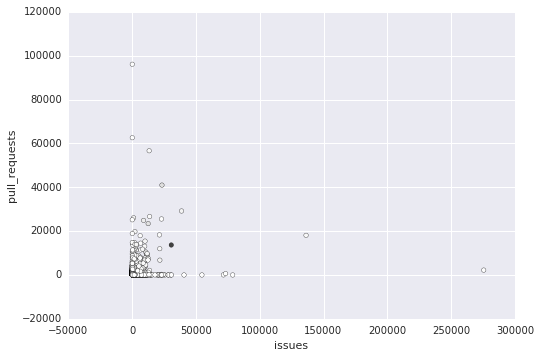

In [85]:
agg_df.plot(kind='scatter', x='issues', y='pull_requests', c=agg_df['fork_events'])

In [87]:
agg_df.std()

fork_events       570.136142
issues           1430.718704
pull_requests     712.321660
dtype: float64

In [92]:
outliers = agg_df[agg_df.apply(lambda x: np.abs(x - x.mean()) / x.std() > 3).all(axis=1)]

In [93]:
outliers.head()

,fork_events,issues,pull_requests
repository_name,,,
TrinityCore,7095,21615,6747
android,13951,8638,3297
angular.js,16986,10545,10470
ansible,4317,9767,13113
blog,4484,5589,4755


In [95]:
norms = agg_df[agg_df.apply(lambda x: np.abs(x - x.mean()) / x.std() <= 3).all(axis=1) ]

In [96]:
norms.head()

,fork_events,issues,pull_requests
repository_name,,,
---,50,23,56
----,24,830,11
-------------,0,58,0
---------------,0,126,0
--LIVE99.TK-,0,88,0


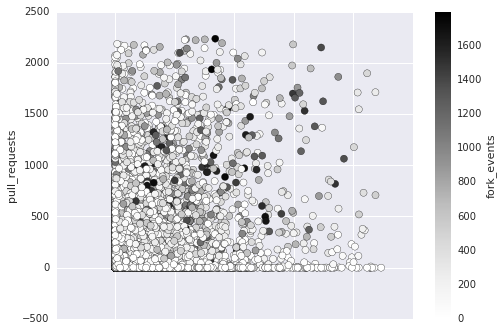

In [104]:
norms.plot(kind='scatter', x='issues', y='pull_requests', c='fork_events', s=50)

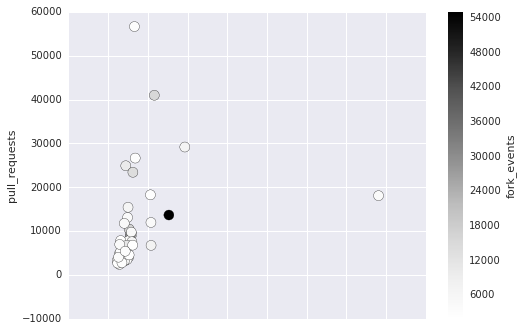

In [102]:
outliers.plot(kind='scatter', x='issues', y='pull_requests', c='fork_events', s=100)

### Possible next questions: 
- Does the correlation vary based on number of contributors? Language?
- Focus only on past year of history
- Focus only on repositories with / without a certain number of contributors or only "active" (i.e. have had at least 10 commits in past 3 months).
